In [1]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
from datetime import datetime, timedelta

from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')

In [3]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

In [4]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['default'] = 0 # в тесте у нас нет значения Default, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

Описания полей
client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

SCH - school - те, у кого среднее образование (только школа).
UGR - undergraduate - бакалавры.
GRD - магистры
PGR - postgraduate - учёная степень PhD (кандидаты наук по-нашему)
ACD - высший уровень. Можно считать высшей категорией.
Таким образом, если упорядочить по возрастанию уровня образования, получим следующий список:
SCH, UGR, GRD, PGR, ACD. (отредактировано) 

In [5]:
def get_scores(report_df, model, X_test, y_test, name):
    '''Create and add metrics into a pandas DF after experiment'''

    report = pd.DataFrame(columns={'ROC-AUC'}, data=[0])
    report['ROC-AUC'] = roc_auc_score(y_test,
                                      model.predict_proba(X_test)[:, 1])
    report['PR-AUC'] = precision_score(y_test,model.predict(X_test))
    report['F1'] = f1_score(y_test, model.predict(X_test))
    report['precision_Neg'] = precision_score(
        y_test, model.predict(X_test), pos_label=0)
    report['precision_Pos'] = precision_score(
        y_test, model.predict(X_test), pos_label=1)
    report['recall_Neg'] = recall_score(
        y_test, model.predict(X_test), pos_label=0)
    report['recall_Pos'] = recall_score(
        y_test, model.predict(X_test), pos_label=1)

    report.index = [name]
    report_df = report_df.append(report)
    return report_df

In [6]:
def detect_outliers(data):
    '''Function is called to detect outliers'''
    q1, q3 = np.percentile(sorted(data), [25, 75])

    IQR = q3 - q1

    l_b = q1 - (1.5 * IQR) # lower bound
    u_b = q3 + (1.5 * IQR) # upper bound
    outl_count = len(data[data < l_b]) + len(data[data > u_b])

    print(
        f'Lower Bound: {round(l_b,3)}, Upper Bound {round(u_b,3)}, Outliers Count: {outl_count}')

In [7]:
data.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default', 'sample'],
      dtype='object')

дописать log_loss

EDA

Ссылка на pandasprofiling [Обычная ссылка в строке](https://www.google.com)

In [8]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'region_rating','home_address', 'work_address',
            'sna','first_time']
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki']
date_cols = ['app_date']

Посмотрим выбросы

In [9]:
for col in num_cols:
    print(col)
    detect_outliers(data[col])

age
Lower Bound: 3.0, Upper Bound 75.0, Outliers Count: 0
decline_app_cnt
Lower Bound: 0.0, Upper Bound 0.0, Outliers Count: 18677
income
Lower Bound: -22000.0, Upper Bound 90000.0, Outliers Count: 7000
bki_request_cnt
Lower Bound: -4.5, Upper Bound 7.5, Outliers Count: 2636
score_bki
Lower Bound: -3.299, Upper Bound -0.529, Outliers Count: 518


'client_id' удалим

* app_date
   преобразовать
* education
   пропуски
   LabelEncoding
* sex
   LabelEncoding
* age
   Смещенное распределение
   Перевести в категории или логарифмировать
* car и car_type
   высокая корреляция с car_type
   LabelEncoding
   объеденить с car_type
* decline_app_cnt
   много нулевых значений
   много выбросов
   перевести в категории или логарифмировать
* good_work
   все ок
* score_bki
   есть выбросы
   перевести в категорию?
* bki_request_cnt
   много нулевых значений
   есть выбросы
   перевести в категории или логарифмировать
* region_rating
   слегка смещенное распределение
   логарифмировать?
* home_address и work_address
   высокая корреляция с work_address
   объеденить с work_address
* income
   Смещенное распределение
   есть выбросы
   Перевести в категории или логарифмировать
* sna и first_time
   высокая корреляция с first_time
   объеденить с first_time
* foreign_passport
   LabelEncoding
* default
   Целевая переменная. Не сбалансированная выборка. Количество одного
   класса сильно больше количества второго класса.
   Пробовать веса классов или добавать в выборку больше значений
   класса меньшинства.

Обработаем даты

In [10]:
for col in date_cols:
    data[col] = pd.to_datetime(data[col])

In [11]:
data['app_date']

0        2014-03-22
1        2014-01-24
2        2014-03-23
3        2014-02-03
4        2014-02-04
            ...    
110143   2014-03-04
110144   2014-03-24
110145   2014-04-22
110146   2014-01-04
110147   2014-01-23
Name: app_date, Length: 110148, dtype: datetime64[ns]

Заполним пропуски модой

In [12]:
mod_edu = data['education'].mode()
data['education'] = data['education'].fillna(mod_edu[0])

In [13]:
# imp = SimpleImputer(strategy='most_frequent')
# imp.fit(data)

# data = imp.transform(data)

# data = pd.DataFrame(data)

Обучим наивную модель для сравнения

In [14]:
data_naive = data[['client_id', 'age',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'sample', 'default']]

In [15]:
# Теперь выделим тестовую часть
train_data = data_naive.query('sample == 1').drop(['sample'], axis=1)
test_data = data_naive.query('sample == 0').drop(['sample'], axis=1)

y = train_data.default.values            # наш таргет
X = train_data.drop(['default'], axis=1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [17]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[12933,     0],
       [ 1827,     0]], dtype=int64)

Модуль sklearn выдаёт матрицу ошибок в следующем виде: TN FP FN TP

In [18]:
f1_score(y_test, y_pred)

0.0

In [19]:
accuracy_score(y_test, y_pred)

0.876219512195122

In [20]:
recall_score(y_test, y_pred)

0.0

In [21]:
precision_score(y_test, y_pred)

C:\Users\negat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [22]:
print(classification_report(y_test, y_pred, output_dict=False))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     12933
           1       0.00      0.00      0.00      1827

    accuracy                           0.88     14760
   macro avg       0.44      0.50      0.47     14760
weighted avg       0.77      0.88      0.82     14760



C:\Users\negat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\negat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\negat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
probs = model.predict_proba(X_test)
#probs = probs[:,1]

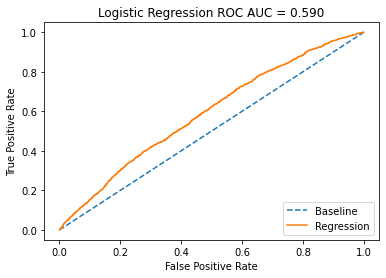

In [24]:
fpr, tpr, threshold = roc_curve(y_test, probs[:,1])
roc_auc = roc_auc_score(y_test, probs[:,1])

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [25]:
df_report = pd.DataFrame(data=None)

In [26]:
df_report = get_scores(df_report, model, X_test, 
                       y_test, 'LogisticRegression_Naive')

C:\Users\negat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\negat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
df_report

,ROC-AUC,PR-AUC,F1,precision_Neg,precision_Pos,recall_Neg,recall_Pos
LogisticRegression_Naive,0.589633,0.0,0.0,0.87622,0.0,1.0,0.0


In [28]:
log_loss(y_test, probs)

0.36890218945748554

In [102]:
# kf = KFold(n_splits=5)
# cross_val_score(model, X, y, cv=kf, scoring="accuracy")

In [33]:
# clf = LogisticRegressionCV(cv=5, random_state=0).fit(X, y)
# clf.predict(X)
# clf.predict_proba(X).shape
# y_pred2 = clf.predict(X)
# clf.score(X, y)
# confusion_matrix(y, y_pred2)
# probs2 = clf.predict_proba(X)
# probs2 = probs2[:,1]
# probs2 = clf.predict_proba(X)
# roc_auc_score(y, probs2[:,1])
# log_loss(y, probs2)

Померим переобучение

In [29]:
cv_metrics = cross_validate(model, X, y, cv=5, scoring='f1_micro', return_train_score=True)

In [30]:
def plot_cv_metrics(cv_metrics):
    avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
    avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
    print('[train] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_train, std_f1_train))
    print('[valid] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_valid, std_f1_valid))
    
    plt.figure(figsize=(15, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='valid', marker='.')

    plt.ylim([0., 1.]);
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('F1-score', fontsize=15)
    plt.legend(fontsize=15)

[train] F1-score = 0.87 +/- 0.00
[valid] F1-score = 0.87 +/- 0.00


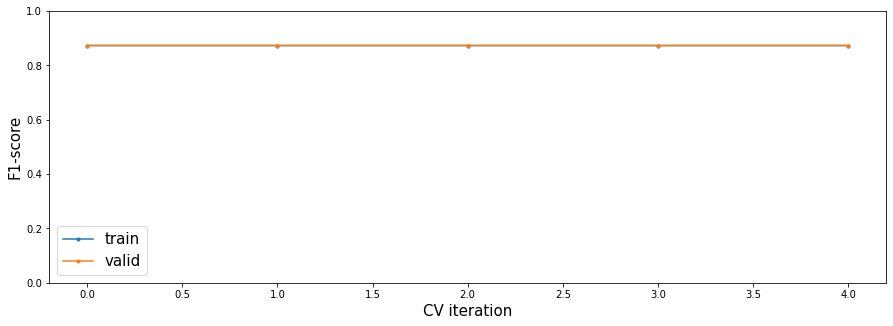

In [31]:
plot_cv_metrics(cv_metrics)

сюда скопировать создание файла submission

Посмотрим распределение логарифмированных 

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


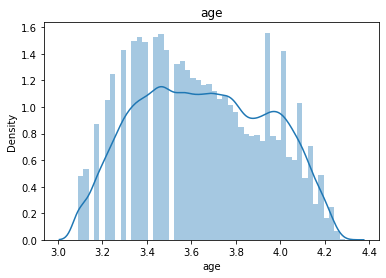

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


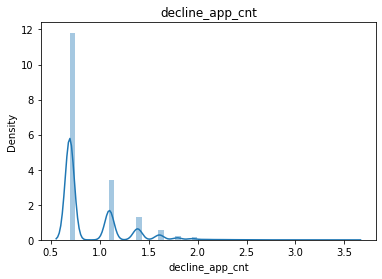

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


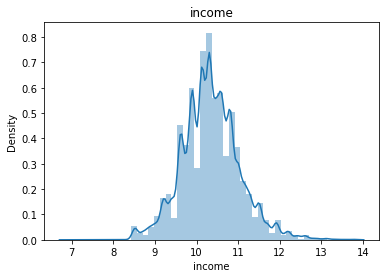

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


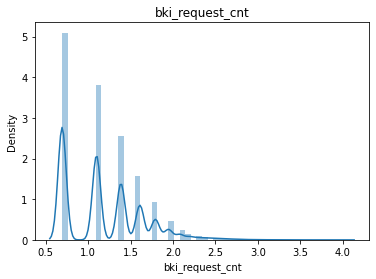

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


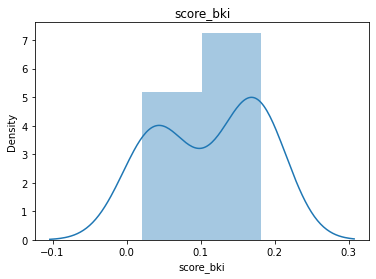

In [32]:
for col in num_cols:
    plt.figure()
    sns.distplot(np.log(data[col][data[col] > 0].dropna() +1))
    plt.title(col)
    plt.show()

income и age приобрели распределение похожее на нормальное

In [33]:
col_for_log = ['income', 'age']

In [38]:
for col in col_for_log:
    data[col+'_log'] =np.log(data[col])
    num_cols.append(col+'_log')

посмотрим boxplot числовых признаков

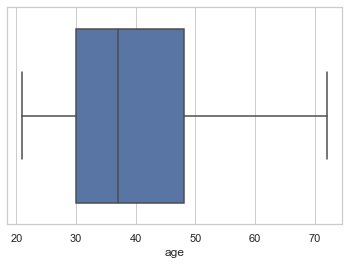

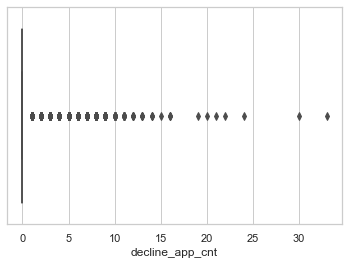

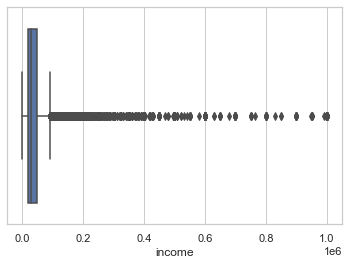

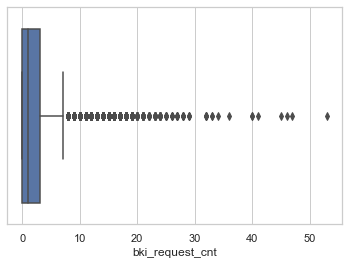

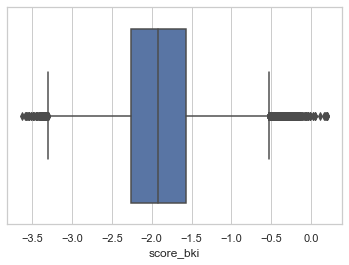

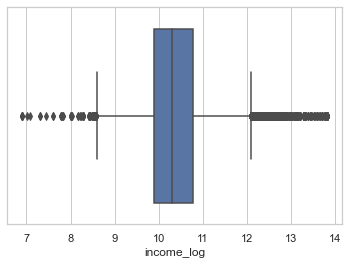

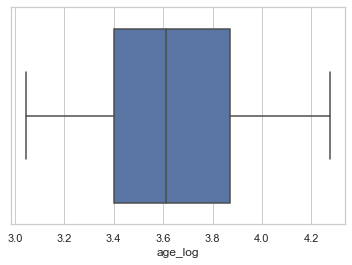

In [48]:
for i in num_cols:
    sns.set_theme(style="whitegrid")
    ax = sns.boxplot(x=data[i])
    plt.show()

разделим decline_app_cnt на две категории: были отказы и не было

In [53]:
data['decline_app'] = data['decline_app_cnt'].apply(lambda x: 0 if x == 0 else 1)

разделим income на три категории low, mid и hi (0, 1, 2)

In [81]:
q1, q3 = np.percentile(sorted(data['income']), [25, 75])

In [88]:
data['income_cat'] = data['income'].apply(lambda x: 0 if x < q1 else (2 if x > q3 else 1))

In [89]:
data['income_cat'].value_counts()

1    59003
2    27344
0    23801
Name: income_cat, dtype: int64

разделим bki_request_cnt на две категории low и  hi (0, 1)

In [91]:
data['bki_request'] = data['bki_request_cnt'].apply(lambda x: 0 if x <= 0 else 1)

In [92]:
data['bki_request'].value_counts()

1    81240
0    28908
Name: bki_request, dtype: int64

<AxesSubplot:title={'center':'По датам'}>

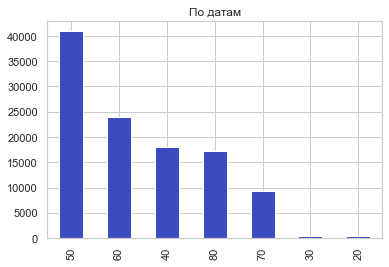

In [58]:
data['region_rating'].value_counts().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'По датам')

<AxesSubplot:xlabel='default', ylabel='income'>

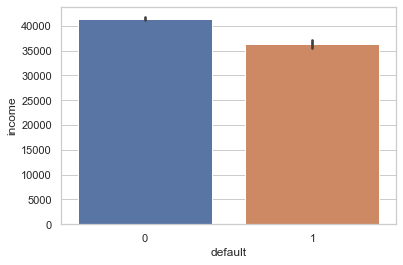

In [70]:
sns.barplot(x='default', y='income', data=data)

<AxesSubplot:xlabel='default', ylabel='age'>

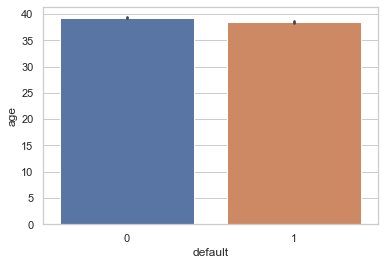

In [71]:
sns.barplot(x='default', y='age', data=data)

<AxesSubplot:xlabel='region_rating', ylabel='default'>

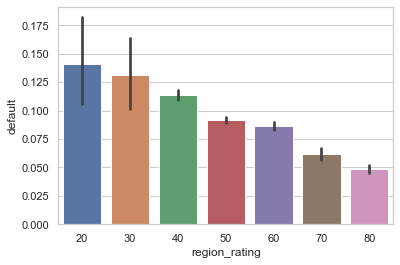

In [75]:
sns.barplot(x='region_rating', y='default', data=data)

<AxesSubplot:xlabel='default', ylabel='sex'>

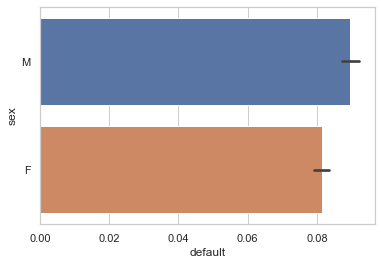

In [74]:
sns.barplot(x='default', y='sex', data=data)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='default', ylabel='income'>

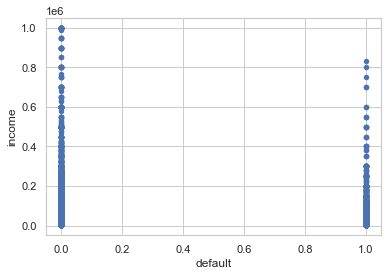

In [76]:
data.plot(x='default', y='income', kind='scatter', grid=True)

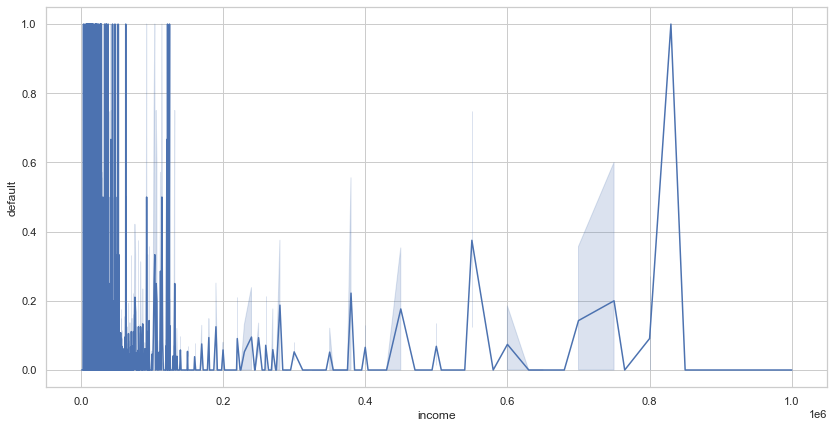

In [66]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=data, x='income', y='default');

функции обучения из интернета, потом посмотреть

In [ ]:
def fit_model(self, X, y):
        """
        X::pd.DataFrame: Input data
        y::np.ndarray: response for input data
        """
        X = X.values
        XY = np.hstack((X, y[:, None]))
        np.random.shuffle(XY)
        X = XY[:, :-1]
        y = XY[:, -1]
        cv_out = StratifiedShuffleSplit(n_splits=400)
        cv_in = StratifiedKFold(n_splits=5)
        clf = Pipeline([('scaler', StandardScaler()),
                        ('lg', linear_model.LogisticRegressionCV(
                                  penalty='l1',
                                  solver='liblinear',
                                  cv=cv_in))])

        self.res = {'coef':[], 'auc':[], 'model':0}

        for idx, (train, test) in enumerate(cv_out.split(X, y)):
            clf.fit(X[train], y[train])
            prediction = clf.predict(X[test])
            self.res['coef'].append((idx, clf.named_steps['lg'].coef_[0]))
            self.res['auc'].append((idx, roc_auc_score(y[test], prediction)))

        self.res['model'] = clf

        output_saved = self.save_pickle(self.res, self.out)
        return output_saved

In [ ]:
def validate(self):
        '''
        Ten-fold cross-validation with stratified sampling.
        '''
        print('Validating new model: {}()'.format(self.__class__.__name__))

        accuracy_scores = []
        precision_scores = []
        recall_scores = []
        f1_scores = []

        sss = StratifiedShuffleSplit(n_splits=10)
        for train_index, test_index in sss.split(self.data, self.labels):
            x_train, x_test = self.data[train_index], self.data[test_index]
            y_train, y_test = self.labels[train_index], self.labels[test_index]

            model = self.create_model()
            model.fit(x_train, y_train, epochs=100, batch_size=128,
                      class_weight=self.class_weight)
            y_pred = model.predict_classes(x_test, batch_size=128)

            accuracy_scores.append(accuracy_score(y_test, y_pred))
            precision_scores.append(precision_score(y_test, y_pred))
            recall_scores.append(recall_score(y_test, y_pred))
            f1_scores.append(f1_score(y_test, y_pred))

        print('')
        print('Accuracy: {}'.format(np.mean(accuracy_scores)))
        print('Precision: {}'.format(np.mean(precision_scores)))
        print('Recall: {}'.format(np.mean(recall_scores)))
        print('F1-measure: {}'.format(np.mean(f1_scores)))

кросс валидация на разных параметрах и на стратифицированной выборке

In [67]:
# sss_outer = StratifiedShuffleSplit(n_splits=5, test_size=0.4, random_state=15)
# sss_inner = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=16)
# pipe_logistic = Pipeline([('scl', StandardScaler()),('clf', LogisticRegression(penalty='l2'))])
# parameters = {'clf__C': np.logspace(-4,1,50)}
# grid_search = GridSearchCV(estimator=pipe_logistic, param_grid=parameters, verbose=1, scoring='f1', cv=sss_inner)

In [81]:
from sklearn.metrics import recall_score

In [82]:
# scoring = ['precision_macro', 'recall_macro']
# scores = cross_validate(grid_search, X, y, scoring=scoring)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [83]:
sorted(scores.keys())

['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']

In [84]:
scores['test_recall_macro']

array([0.51029912, 0.50632138, 0.51001102, 0.51139806, 0.51334548])

In [68]:
cross_val_score(grid_search, X, y, cv=sss_inner)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits


array([0.04781282, 0.04261796, 0.04853387])

In [79]:
grid_search.fit(X, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=16, test_size=0.2,
            train_size=None),
             estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('clf', LogisticRegression())]),
             param_grid={'clf__C': array([1.00000000e-04, 1.26485522e-04, 1.59985872e-04, 2.02358965e-04,
       2.55954792e-04, 3.23745754e-04, 4.09491506e-04, 5.17947468e-04,
       6.55128557e-04, 8.286427...
       7.19685673e-02, 9.10298178e-02, 1.15139540e-01, 1.45634848e-01,
       1.84206997e-01, 2.32995181e-01, 2.94705170e-01, 3.72759372e-01,
       4.71486636e-01, 5.96362332e-01, 7.54312006e-01, 9.54095476e-01,
       1.20679264e+00, 1.52641797e+00, 1.93069773e+00, 2.44205309e+00,
       3.08884360e+00, 3.90693994e+00, 4.94171336e+00, 6.25055193e+00,
       7.90604321e+00, 1.00000000e+01])},
             scoring='f1', verbose=1)

In [80]:
grid_search.best_estimator_.get_params()

{'memory': None,
 'steps': [('scl', StandardScaler()),
  ('clf', LogisticRegression(C=0.3727593720314942))],
 'verbose': False,
 'scl': StandardScaler(),
 'clf': LogisticRegression(C=0.3727593720314942),
 'scl__copy': True,
 'scl__with_mean': True,
 'scl__with_std': True,
 'clf__C': 0.3727593720314942,
 'clf__class_weight': None,
 'clf__dual': False,
 'clf__fit_intercept': True,
 'clf__intercept_scaling': 1,
 'clf__l1_ratio': None,
 'clf__max_iter': 100,
 'clf__multi_class': 'auto',
 'clf__n_jobs': None,
 'clf__penalty': 'l2',
 'clf__random_state': None,
 'clf__solver': 'lbfgs',
 'clf__tol': 0.0001,
 'clf__verbose': 0,
 'clf__warm_start': False}

Создаем файл на оценку

In [62]:
test_data.sample(10)

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
4169,34439,54,0,0,-2.171573,1,50,2,2,50000,1,4,0
28512,2428,31,0,1,-1.373887,1,80,2,3,25000,1,4,0
32591,9156,30,3,0,-1.729726,1,50,1,2,28000,1,2,0
17009,21551,28,2,1,-1.371041,0,50,2,3,40000,1,4,0
1419,32238,46,0,0,-2.162422,4,60,1,2,35000,1,4,0
21059,99199,41,0,0,-1.985802,3,60,2,3,20000,4,2,0
2146,15563,38,0,1,-2.149256,0,40,1,3,60000,1,3,0
3117,28978,40,0,0,-1.910075,0,80,2,3,47000,2,2,0
6677,64465,36,0,0,-1.844057,3,50,2,3,100000,1,3,0
26121,44849,23,0,1,-1.169784,0,40,1,2,14000,1,4,0


In [63]:
test_data = test_data.drop(['default'], axis=1)

In [64]:
predict_submission = model.predict_proba(test_data)

In [66]:
test_client_id = pd.DataFrame()

In [67]:
test_client_id['client_id'] = test_data['client_id']

In [68]:
predict_submission[:,1]

array([0.14341248, 0.16829189, 0.11564932, ..., 0.13449015, 0.118233  ,
       0.14092088])

In [69]:
test_client_id['default'] = predict_submission[:,1]
test_client_id.to_csv('submission.csv', index=False)
test_client_id.head(10)

,client_id,default
0,74835,0.143412
1,17527,0.168292
2,75683,0.115649
3,26883,0.154027
4,28862,0.077724
5,99881,0.100012
6,26630,0.152253
7,79934,0.096744
8,16605,0.108159
9,105449,0.072841


In [70]:
test_client_id.describe()

,client_id,default
count,36349.000000,36349.000000
mean,54945.647473,0.128056
std,31706.052195,0.036409
min,4.000000,0.007923
25%,27744.000000,0.101707
50%,54657.000000,0.126571
75%,82322.000000,0.152765
max,110148.000000,0.321245


EDA

In [ ]:
# Ищем самые значсимые признаки среди числовых
def impotant_muncols(cols, data):
  imp_num = pd.Series(f_classif(data.query('sample == 1')[cols], data.query('sample == 1')['default'])[0], index = cols)
  imp_num.sort_values(inplace = True)
  imp_num.plot(kind = 'barh', figsize=(15,10))
  return ''

# Функция анализа категориальных переменных
def category_info(data, col):
    plt.figure(figsize=(15, 4))
    plt.subplot(121)
    sns.distplot(data[col].values, bins=7, color='#a1c9e0')
    plt.title(' распределение ' + col, fontsize=15)
    plt.xlabel(col)
    plt.ylabel('Quantity (frequency)')
            
    # boxplot: распределение признака по целевой переменной
    plt.subplot(122)
    sns.boxplot(x=data.query('sample == 1')['default'], y=data.query('sample == 1')[col])
    plt.title(col + ': distribution by default', fontsize=15)
    plt.xlabel('default')
    plt.ylabel(col)
    plt.show()

# Вспомогательная функция определения значимых признаков

def impotant_feature(data, col, key):
    cols = data.loc[:, col].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data.loc[data.loc[:, col] == comb[0], key],
                     data.loc[data.loc[:, column] == comb[1], key]).pvalue \
                <= 0.05/len(combinations_all):
            print('обнаружена статистическая значимость измерения: ', col)
            break

In [108]:
data[bool_cols]

,sex,car,car_type,good_work,foreign_passport
0,M,Y,Y,0,N
1,F,N,N,0,N
2,M,Y,Y,0,Y
3,M,N,N,0,N
4,F,N,N,0,N
...,...,...,...,...,...
110143,F,N,N,0,N
110144,M,Y,Y,0,N
110145,M,N,N,0,N
110146,F,N,N,1,N


Преобразуем дату

In [26]:
pd.to_datetime(data.app_date)

0        2014-03-22
1        2014-01-24
2        2014-03-23
3        2014-02-03
4        2014-02-04
            ...    
110143   2014-03-04
110144   2014-03-24
110145   2014-04-22
110146   2014-01-04
110147   2014-01-23
Name: app_date, Length: 110148, dtype: datetime64[ns]

In [ ]:
df.app_date.dt.weekday

In [ ]:
bool_cols = [
    'sex', 'car', 'car_type', 
    'good_work', 'foreign_passport'
]

cat_cols = [
    'education', 'region_rating',
    'home_address', 'work_address',
    'sna','first_time'
]

num_cols = [
    'age', 'decline_app_cnt', 'income', 
    'bki_request_cnt', 'score_bki'
]
date_cols = ['app_date']

распределение по бинарным и категориальным переменным

In [ ]:
plt.figure(figsize=[20, 20])
i = 1

for k in bool_cols:
    plt.subplot(4, 3, i)
    sns.barplot(x=k,
                y='proportion',
                hue='default',
                data=df_train[[k, 'default']].value_counts(
                    normalize=True).rename('proportion').reset_index(),
                palette=[colors[3], colors[4]])
    plt.title('Binary Feature Name\n' + k, fontsize=15)
    i += 1
plt.tight_layout()
plt.show()

In [ ]:
def get_boxplot(data, col1, col2, hue=None):
    '''Function is called to plot boxplots'''
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.boxplot(x=col1, y=col2, hue=hue, data=data, palette=colors)
    plt.xticks(rotation=45)
    ax.set_title(f'Boxplot for {col1} and {col2}', fontsize=14)
    plt.show()

функция для метрики

In [ ]:
def make_roc_auc(model, X, y):
    '''Plot ROC-AUC and PR curves'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
    plot_precision_recall_curve(model, X, y, ax=ax1)
    plot_roc_curve(model, X, y, ax=ax2)
    plt.show()

Feature Engineering — способ создания признаков, техника решения задач МО, которая увеличивает качество разрабатываемых алгоритмов. Превращает специфичные данные в понятные для модели векторы.

Способы:

Ручное создание признаков
Новые признаки можно создавать на основе имеющихся, если понятно, что означает тот или иной признак. Техника может значительно улучшить модель, но требуется погружение в предметную область. Например, зная массу и рост человека, можно посчитать индекс массы тела; зная координаты места нарушения ПДД и центра города, можно посчитать расстояние между ними.
Полиномиальные признаки
Например, попарное перемножение имеющихся столбцов, чтобы получить нелинейные комбинации признаков. Другой пример — возведение признаков в квадрат или корень из признака, чтобы получить искусственные признаки.
Dummy-переменные
Между категориальными признаками не всегда есть порядок, поэтому их следует заменять на dummy-переменные, в виде цифр, чтобы алгоритм подумал, что в данных есть порядок. Например, лев, тигр, медведь лучше записать как 0, 1, 2. Расстояние между «лев» и «тигр» равно 1, а между «лев» и «медведь» — 2, хотя это не так. Решение — создать новые признаки по количеству категорий. Для признака «лев» значение будет 1, если это лев, иначе 0. Теперь расстояния между всеми признаками равны 1.
Работа с датой/временем
Обычно дата — это строка, похожая на «2005-06-02». В таком виде признак имеет мало смысла, но его можно разделить на набор других признаков. Модель не принимает текст, поэтому заменяем его на набор других числовых признаков. Например, день, месяц, год или день недели, праздник/выходной.
Статистики по наборам признаков
Если в данных есть признаки, описывающие значение в разные моменты времени, то они могут быть полезными. Например, зарплата_2016, зарплата_2017, зарплата_2018. Отсюда можно вытащить среднюю зарплату за 3 года, медианную зарплату, динамику зарплаты, максимальную и минимальную зарплату.